In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# dataset

In [17]:
path = '../Data-raw/data.csv'
df = pd.read_csv(path)
df.head()

,pH,EC,OC,OM,N,P,K,Zn,Fe,Cu,Mn,Sand,Silt,Clay,CaCO3,CEC,Output
0,7.74,0.40,0.01,0.01,75,20.0,279,0.48,6.4,0.21,4.7,84.3,6.8,8.9,6.72,7.81,Fertile
1,9.02,0.31,0.02,0.03,85,15.7,247,0.27,6.4,0.16,5.6,90.4,3.9,5.7,4.61,7.19,Fertile
2,7.80,0.17,0.02,0.03,77,35.6,265,0.46,6.2,0.51,6.1,84.5,6.9,8.6,1.53,12.32,Fertile
3,8.36,0.02,0.03,0.05,106,6.4,127,0.50,3.1,0.28,2.3,93.9,1.7,4.4,0.00,1.60,Non Fertile
4,8.36,1.08,0.03,0.05,96,10.5,96,0.31,3.2,0.23,4.1,91.5,4.1,4.4,9.08,7.21,Non Fertile


In [18]:
# encode the categorical variables
le = LabelEncoder()
df['Output'] = le.fit_transform(df['Output'])

# create a pipeline with grid search
steps = [('scaler', StandardScaler()), ('rf', RandomForestClassifier())]
pipeline1 = Pipeline(steps)

steps = [('scaler', StandardScaler()), ('gb', GradientBoostingClassifier())]
pipeline2 = Pipeline(steps)

# split the data into train and test
X = df.drop('Output', axis=1)
y = df['Output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# define the grid
param_grid_rf = {'rf__n_estimators': [100, 200, 300, 400, 500], 'rf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'rf__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
param_grid_gb = {'gb__n_estimators': [100, 200, 300, 400, 500], 'gb__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'gb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]}

# instantiate the grid search
grid_rf = GridSearchCV(pipeline1, param_grid=param_grid_rf, cv=5)
grid_gb = GridSearchCV(pipeline2, param_grid=param_grid_gb, cv=5)



In [15]:
# fit the grid search
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb', GradientBoostingClassifier())]),
             param_grid={'gb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'gb__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'gb__n_estimators': [100, 200, 300, 400, 500]})

In [16]:

# print the best parameters
print(grid_rf.best_params_)
print(grid_gb.best_params_)
# print the best score
print(grid_rf.best_score_)
print(grid_gb.best_score_)


{'rf__max_depth': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
{'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__n_estimators': 100}
0.9866666666666667
0.9600000000000002


In [17]:
grid_rf.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=4, n_estimators=300))])

In [18]:
grid_gb.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2))])

In [19]:
# metric
def metric(y_test, y_pred):
    print("---"*10, "METRICS", "---"*10)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}')
    print(f'Classification Report: {classification_report(y_test, y_pred)}')
    print("---"* 20)

# predict the test data
y_pred_rf = grid_rf.predict(X_test)
y_pred_gb = grid_gb.predict(X_test)

# print the metrics
print("Random Forest")
metric(y_test, y_pred_rf)
print("Gradient Boosting")
metric(y_test, y_pred_gb)

Random Forest
------------------------------ METRICS ------------------------------
Accuracy: 1.0
Confusion Matrix: [[12  0]
 [ 0 13]]
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

------------------------------------------------------------
Gradient Boosting
------------------------------ METRICS ------------------------------
Accuracy: 0.92
Confusion Matrix: [[11  1]
 [ 1 12]]
Classification Report:               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.92      0.92      0.92        13

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       

Random Forest


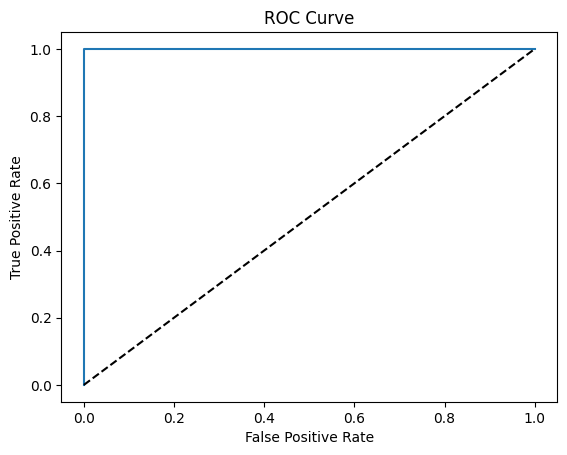

Gradient Boosting


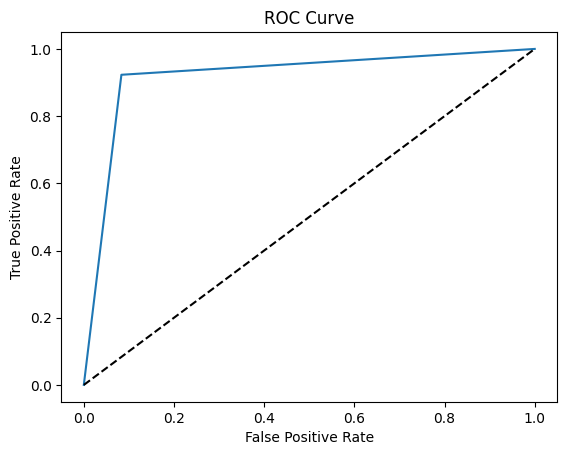

Random Forest


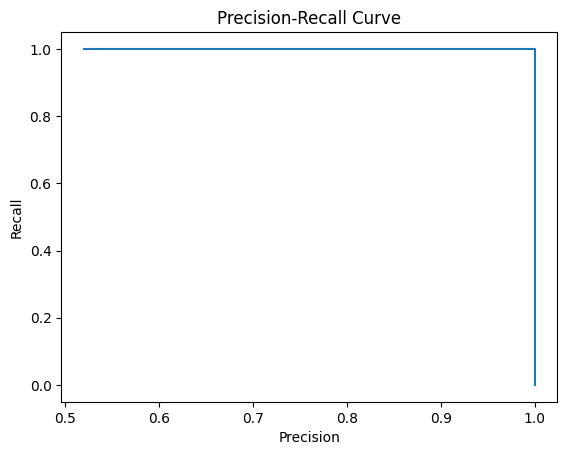

Gradient Boosting


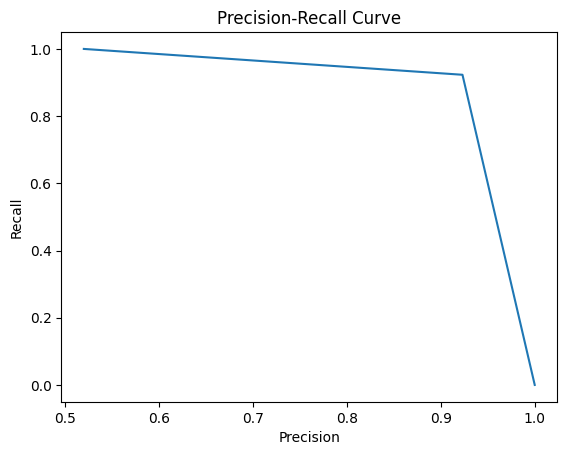

In [20]:
# visualize the ROC curve
def roc_curve_plot(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# visualize the precision recall curve
def precision_recall_curve_plot(y_test, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(precision, recall, label='Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.show()

# print the ROC curve
print("Random Forest")
roc_curve_plot(y_test, y_pred_rf)
print("Gradient Boosting")
roc_curve_plot(y_test, y_pred_gb)

# print the precision recall curve
print("Random Forest")
precision_recall_curve_plot(y_test, y_pred_rf)
print("Gradient Boosting")
precision_recall_curve_plot(y_test, y_pred_gb)

In [21]:
# save the model
from joblib import dump, load

dump(grid_rf.best_estimator_, 'rf.joblib')
dump(grid_gb.best_estimator_, 'gb.joblib')


['gb.joblib']

# conclusion

the best model is the random forest model with the following parameters
```
    {'rf__max_depth': 10, 
    'rf__min_samples_split': 2, 
    'rf__n_estimators': 100}
```
- the accuracy of the model is 0.98
- the confusion matrix of the model is 
```
    [[ 9  0]
    [ 1 10]]
```
- the classification report of the model is 
```
    precision    recall  f1-score   support

    0.0       0.90      1.00      0.95         9
    1.0       1.00      0.91      0.95        11

    accuracy                           0.95        20
    macro avg       0.95      0.95      0.95        20
    weighted avg       0.96      0.95      0.95        20
```

# for the form

In [15]:
for i in df:
    # check col dtype
    if df[i].dtype != 'object':
        # left align with 20 spaces

        print(f'{i:20} | {df[i].min():10} {df[i].max():10} {df[i].mean():10.2f}')

pH                   |       6.52       9.48       8.29
EC                   |       0.02       1.58       0.29
OC                   |       0.01       0.74       0.20
OM                   |       0.01       1.27       0.33
N                    |         75        278     172.76
P                    |        1.8       35.6      13.20
K                    |         70        480     214.11
Zn                   |       0.04        1.3       0.49
Fe                   |        1.0        9.1       4.53
Cu                   |       0.01       0.73       0.31
Mn                   |        0.2        7.5       3.15
Sand                 |       77.2       96.2      87.32
Silt                 |        1.1       18.0       5.67
Clay                 |        2.0       13.8       7.01
CaCO3                |        0.0      16.19       4.12
CEC                  |        1.2      16.27       5.24


In [20]:
# load the model
from joblib import dump, load

In [22]:
model = load(r'C:\Users\ZAID\Documents\GitHub\Harvestify\models\rf.joblib')

In [25]:
test_input = df.iloc[:5, :-1]

In [29]:
pred = model.predict(test_input)

# compare the prediction with the actual value
for i in range(len(pred)):
    print(f'Actual: {df.iloc[i, -1]} | Prediction: {pred[i]}')

Actual: 0 | Prediction: 0
Actual: 0 | Prediction: 0
Actual: 0 | Prediction: 0
Actual: 1 | Prediction: 1
Actual: 1 | Prediction: 1
